# Machine Learning (CS60050)<br> Assignment 3 - Multi Layer Perceptron Classifier

## Topic: Optical Recognition of Handwritten Digits

#### By: (Group 32)<br>Krinal Patel (21CS60R39)<br>Sarvesh Gupta (21CS60R53)

## Deatils of Dataset:
We used pre-processing programs made available by NIST to extract normalized bitmaps of handwritten digits from a pre-printed form. From a total of 43 people, 30 contributed to the training set and different 13 to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of 4x4 and the number of on pixels are counted in each block. This generates an input matrix of 8x8 where each element is an integer in the range 0..16. This reduces dimensionality and gives invariance to small distortions.

#### Attributes of Dataset:
64 input + 1 class attribute<br><br>
All input attributes are integers in the range 0..16.<br>
The last attribute is the class code 0..9

#### Link of Dataset:
Optical Recognition of Handwritten Digits: https://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits

#### Importing all the required libraries:

In [1]:
import numpy as np
np.random.seed(1) 
import pandas as pd
import torch
from torch import nn
torch.manual_seed(1)
import torch.utils.data as data_utils
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.optim as optim
from pandas import DataFrame
import random
random.seed(1)

#### Reading the Training and Testing dataset:

In [2]:
#reading training and test dataset
train_df=pd.read_csv("optdigits.tra",header=None)
test_df=pd.read_csv("optdigits.tes",header=None)

## Data Analysing

#### Shape of Training and Testing Dataset

In [3]:
print("Training set Shape: ",train_df.shape)
print("Test set Shape: ",test_df.shape)

Training set Shape:  (3823, 65)
Test set Shape:  (1797, 65)


#### Top 5 Rows of Train Dataset

In [4]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6


#### Top 5 Rows of Test Dataset

In [5]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


#### Count of examples in each class of training dataset

In [6]:
#last column is target value.
train_df.iloc[:,-1].value_counts()

1    389
3    389
7    387
4    387
9    382
2    380
8    380
6    377
0    376
5    376
Name: 64, dtype: int64

#### Count of examples in each class of testing dataset

In [7]:
#last column is target value.
test_df.iloc[:,-1].value_counts()

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: 64, dtype: int64

#### Details of Training Dataset

In [8]:
train_df.iloc[:,:-1].isnull().any().describe()

count        64
unique        1
top       False
freq         64
dtype: object

#### Details of Test Dataset

In [9]:
test_df.iloc[:,:-1].isnull().any().describe()

count        64
unique        1
top       False
freq         64
dtype: object

#### Normalizing the fetures of Training dataset 

In [10]:
scaler=StandardScaler()
train_x=train_df.iloc[:,:-1]
test_x=test_df.iloc[:,:-1]
train_x=scaler.fit_transform(train_x)
test_x=scaler.transform(test_x)
train_df.iloc[:,:-1]=DataFrame(train_x)
test_df.iloc[:,:-1]=DataFrame(test_x)

#### Top 5 rows of training dataset after normalizing

In [11]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.0,0.805961,0.111894,0.749917,0.120901,-0.802762,-0.411567,-0.135332,-0.023629,1.651237,...,-0.193201,-0.016175,-0.305007,0.028945,0.474631,-0.893790,-0.987089,-0.522794,-0.175741,0
1,0.0,-0.347610,0.975639,0.984700,-1.201570,-0.980941,-0.411567,-0.135332,-0.023629,1.651237,...,-0.193201,-0.016175,-0.305007,0.832261,0.936105,0.709005,-0.640772,-0.522794,-0.175741,0
2,0.0,-0.347610,0.543766,0.749917,1.002548,1.335389,-0.411567,-0.135332,-0.023629,-0.314717,...,-0.193201,-0.016175,-0.305007,0.631432,0.474631,-2.296235,-1.160247,-0.522794,-0.175741,7
3,0.0,-0.347610,-1.183724,-2.067477,-0.099511,1.869927,-0.411567,-0.135332,-0.023629,-0.642376,...,-0.193201,-0.016175,-0.305007,-1.176029,-2.524948,0.709005,-0.813930,-0.522794,-0.175741,4
4,0.0,-0.347610,-0.104043,0.515134,-1.642393,-0.980941,-0.411567,-0.135332,-0.023629,-0.642376,...,-0.193201,-0.016175,-0.305007,-0.372713,0.013157,0.508656,0.051861,-0.522794,-0.175741,6


## MLP Classifier was build using PyTorch

#### Convert Pandas DataFrame to TensorDataset

In [12]:
train_y = torch.tensor(train_df.iloc[:,-1].values.astype(np.int64))
train_x = torch.tensor(train_df.iloc[:,:-1].values.astype(np.float32))
test_y = torch.tensor(test_df.iloc[:,-1].values.astype(np.int64))
test_x = torch.tensor(test_df.iloc[:,:-1].values.astype(np.float32))

train_tensor = data_utils.TensorDataset(train_x, train_y)
test_tensor = data_utils.TensorDataset(test_x, test_y)

trainloader = torch.utils.data.DataLoader(train_tensor, batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(test_tensor, batch_size=1,shuffle=False)

#### Training Neurual Network

In [13]:
def train(iterations,dataloader,optimizer,criterion,model):
    final_loss=0.0
    for epoch in range(iterations): 
        running_loss = 0.0
        for i,data in enumerate(dataloader,0):
            features,labels=data
            optimizer.zero_grad()

            output = model(features)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            final_loss=running_loss
        if(epoch%100==0):
            print(f"Training loss after {epoch+100} epochs : {running_loss/len(dataloader)}")
    return final_loss/len(dataloader)

#### Utility method to get model

In [14]:
def get_model(layer_info):
    layers = []
    if(len(layer_info) == 2):  
        layers.append(nn.Linear(layer_info[0],layer_info[1]))
        layers.append(nn.LogSoftmax(dim=1))
    elif(len(layer_info) == 3):
        layers.append(nn.Linear(layer_info[0],layer_info[1]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_info[1],layer_info[2]))
        layers.append(nn.LogSoftmax(dim=1))
    elif(len(layer_info) == 4):
        layers.append(nn.Linear(layer_info[0],layer_info[1]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_info[1],layer_info[2]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_info[2],layer_info[3]))
        layers.append(nn.LogSoftmax(dim=1))
    model=nn.Sequential(*layers)
    return model

#### Function to get Accuracy of the Model

In [15]:
def get_accuracy(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for i,data in enumerate(testloader,0):
            inputs,labels=data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * (correct / total)

#### Comparision between accuracy and learning rate for all the models

In [16]:
learning_rate = [0.00001, 0.0001, 0.001, 0.01, 0.1]
model_arr = [[64,10],[64,2,10],[64,6,10],[64,2,3,10],[64,3,2,10]]
mat_m = [[0 for i in range(5)] for j in range(5)]
mat_l = [[0 for i in range(5)] for j in range(5)]
best_model_acc=[0]*5
p = 0
q = 0
epochs=1000
for i in model_arr:
    for j in learning_rate:
        model=get_model(i)
        loss=train(epochs,trainloader,optim.SGD(model.parameters(), lr=j),nn.NLLLoss(),model)
        accuracy=get_accuracy(model,testloader)
        print('Final Loss(over training dataset): ',loss,' Test accuracy(over test dataset): ',round(accuracy,3),'%')
        print('--------------------------------------------------------------------------------------------')
        mat_m[p][q] = accuracy
        mat_l[q][p] = accuracy
        best_model_acc[p]=max(best_model_acc[p],accuracy)
        q = q + 1
    q = 0
    p = p + 1

Training loss after 100 epochs : 2.414972897370656
Training loss after 200 epochs : 2.3013177196184795
Training loss after 300 epochs : 2.1930283149083456
Training loss after 400 epochs : 2.092780739068985
Training loss after 500 epochs : 1.9973921378453572
Training loss after 600 epochs : 1.908638487259547
Training loss after 700 epochs : 1.8260524451732636
Training loss after 800 epochs : 1.749120114247004
Training loss after 900 epochs : 1.6764255205790202
Training loss after 1000 epochs : 1.609882754087448
Final Loss(over training dataset):  1.5475383122762045  Test accuracy(over test dataset):  63.216 %
--------------------------------------------------------------------------------------------
Training loss after 100 epochs : 2.379905947049459
Training loss after 200 epochs : 1.5178334693113962
Training loss after 300 epochs : 1.0888322710990905
Training loss after 400 epochs : 0.8545068740844727
Training loss after 500 epochs : 0.7087465584278106
Training loss after 600 epochs :

Training loss after 800 epochs : 1.5668360690275829
Training loss after 900 epochs : 1.4658771892388662
Training loss after 1000 epochs : 1.3875722487767537
Final Loss(over training dataset):  1.3281975905100505  Test accuracy(over test dataset):  53.478 %
--------------------------------------------------------------------------------------------
Training loss after 100 epochs : 2.3705049912134806
Training loss after 200 epochs : 1.136961739261945
Training loss after 300 epochs : 0.717879771689574
Training loss after 400 epochs : 0.5249794349074364
Training loss after 500 epochs : 0.4125906050205231
Training loss after 600 epochs : 0.33956513230999313
Training loss after 700 epochs : 0.2890802023311456
Training loss after 800 epochs : 0.2534840720395247
Training loss after 900 epochs : 0.22631893418729304
Training loss after 1000 epochs : 0.2062643438577652
Final Loss(over training dataset):  0.19011199635763962  Test accuracy(over test dataset):  91.486 %
----------------------------

Training loss after 200 epochs : 1.6685592790444692
Training loss after 300 epochs : 1.5050586819648744
Training loss after 400 epochs : 1.379820748170217
Training loss after 500 epochs : 1.319842481613159
Training loss after 600 epochs : 1.2849681516488394
Training loss after 700 epochs : 1.2543673495451608
Training loss after 800 epochs : 1.2304531693458558
Training loss after 900 epochs : 1.2101898570855458
Training loss after 1000 epochs : 1.1894882798194886
Final Loss(over training dataset):  1.169424194097519  Test accuracy(over test dataset):  48.47 %
--------------------------------------------------------------------------------------------
Training loss after 100 epochs : 2.307416391372681
Training loss after 200 epochs : 0.8106786886850993
Training loss after 300 epochs : 0.6802849968274435
Training loss after 400 epochs : 0.6427071367700895
Training loss after 500 epochs : 0.6222422152757645
Training loss after 600 epochs : 0.606269297003746
Training loss after 700 epochs :

#### mat[i][j]=k means ith model with j'th learning rate has accuracy k

In [17]:
mat_m

[[63.21647189760712,
  91.70840289371174,
  93.87868670005565,
  94.93600445186422,
  94.76905954368392],
 [21.59154145798553,
  29.437952142459658,
  51.58597662771286,
  69.78297161936561,
  73.06622148024485],
 [7.90205898720089,
  53.47801892042293,
  91.48580968280467,
  93.82303839732889,
  92.87701725097385],
 [9.961046188091263,
  29.716193656093488,
  57.42904841402338,
  75.45909849749583,
  70.39510294936005],
 [14.134668892598775,
  17.417918753478016,
  62.99387868670006,
  48.46967167501391,
  75.45909849749583]]

#### Learning Rate vs Accuracy for different Models

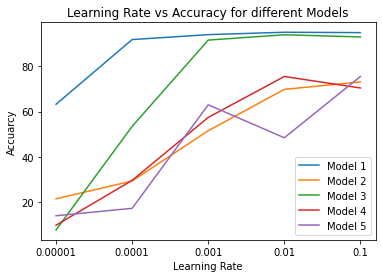

In [18]:
learning_rate_g = ['0.00001', '0.0001', '0.001', '0.01', '0.1']
model_arr_g = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']

plt.plot(learning_rate_g, mat_m[0], label = "Model 1")
plt.plot(learning_rate_g, mat_m[1], label = "Model 2")
plt.plot(learning_rate_g, mat_m[2], label = "Model 3")
plt.plot(learning_rate_g, mat_m[3], label = "Model 4")
plt.plot(learning_rate_g, mat_m[4], label = "Model 5")

plt.xlabel('Learning Rate')
plt.ylabel('Accuarcy')
plt.title('Learning Rate vs Accuracy for different Models')
plt.legend(loc='lower right')
plt.show()

#### Models vs Accuracy for different Learning Rates

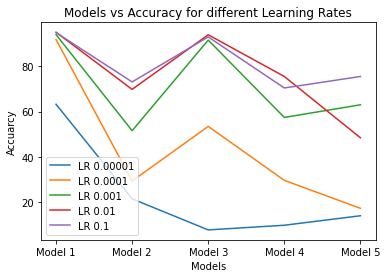

In [19]:
plt.plot(model_arr_g, mat_l[0], label = "LR 0.00001")
plt.plot(model_arr_g, mat_l[1], label = "LR 0.0001")
plt.plot(model_arr_g, mat_l[2], label = "LR 0.001")
plt.plot(model_arr_g, mat_l[3], label = "LR 0.01")
plt.plot(model_arr_g, mat_l[4], label = "LR 0.1")

plt.xlabel('Models')
plt.ylabel('Accuarcy')
plt.title('Models vs Accuracy for different Learning Rates')
plt.legend(loc='lower left')
plt.show()

## Reduction of feature dimension using PCA

#### PCA Implemenatation

In [20]:
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_df.iloc[:,:-1])
test_pca=pca.transform(test_df.iloc[:,:-1])

Text(0, 0.5, 'Second principle component')

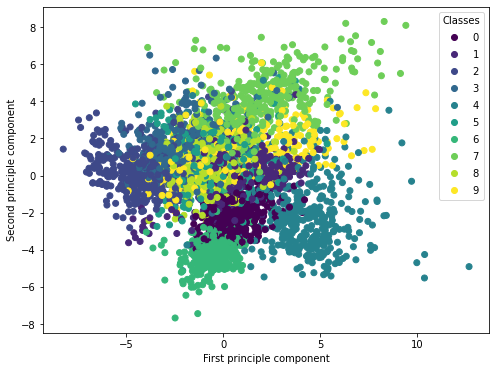

In [21]:
plt.figure(figsize=(8,6))
sc=plt.scatter(train_pca[:,0],train_pca[:,1],c=train_df.iloc[:,-1])
plt.legend(*sc.legend_elements(), loc="upper right", title="Classes")
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

#### Above Implementation after PCA

In [22]:
train_y1 = torch.tensor(train_df.iloc[:,-1].values.astype(np.int64))
train_x1 = torch.tensor(train_pca.astype(np.float32))
test_y1 = torch.tensor(test_df.iloc[:,-1].values.astype(np.int64))
test_x1 = torch.tensor(test_pca.astype(np.float32))

train_tensor1 = data_utils.TensorDataset(train_x1, train_y1)
test_tensor1 = data_utils.TensorDataset(test_x1, test_y1)

trainloader1 = torch.utils.data.DataLoader(train_tensor1, batch_size=64,shuffle=True)
testloader1 = torch.utils.data.DataLoader(test_tensor1, batch_size=1,shuffle=False)

#### Comparision between accuracy and learning rate for all the models

In [23]:
learning_rate1 = [0.00001, 0.0001, 0.001, 0.01, 0.1]
model_arr1 = [[2,10],[2,2,10],[2,6,10],[2,2,3,10],[2,3,2,10]]
mat_m1 = [[0 for i in range(5)] for j in range(5)]
mat_l1 = [[0 for i in range(5)] for j in range(5)]
best_model_acc1=[0]*5
p = 0
q = 0
epochs=1000
for i in model_arr1:
    for j in learning_rate1:
        model=get_model(i)
        loss=train(epochs,trainloader1,optim.SGD(model.parameters(), lr=j),nn.NLLLoss(),model)
        accuracy=get_accuracy(model,testloader1)
        print('Final Loss(over training dataset): ',loss,' Test accuracy(over test dataset): ',round(accuracy,3),'%')
        print('--------------------------------------------------------------------------------------------')
        mat_m1[p][q] = accuracy
        mat_l1[q][p] = accuracy
        best_model_acc1[p]=max(best_model_acc1[p],accuracy)
        q = q + 1
    q = 0
    p = p + 1

Training loss after 100 epochs : 3.647972349325816
Training loss after 200 epochs : 3.531555183728536
Training loss after 300 epochs : 3.4193235437075296
Training loss after 400 epochs : 3.3149976332982383
Training loss after 500 epochs : 3.2131190220514934
Training loss after 600 epochs : 3.11745658715566
Training loss after 700 epochs : 3.0268667101860047
Training loss after 800 epochs : 2.9379974842071532
Training loss after 900 epochs : 2.8545863469441732
Training loss after 1000 epochs : 2.7778807202974956
Final Loss(over training dataset):  2.7029157638549806  Test accuracy(over test dataset):  3.951 %
--------------------------------------------------------------------------------------------
Training loss after 100 epochs : 3.108457044760386
Training loss after 200 epochs : 2.3264079372088116
Training loss after 300 epochs : 1.955261806646983
Training loss after 400 epochs : 1.769112131992976
Training loss after 500 epochs : 1.663902332385381
Training loss after 600 epochs : 1.

Training loss after 900 epochs : 1.55836341381073
Training loss after 1000 epochs : 1.5294275363286336
Final Loss(over training dataset):  1.5048324147860208  Test accuracy(over test dataset):  42.126 %
--------------------------------------------------------------------------------------------
Training loss after 100 epochs : 2.5159982442855835
Training loss after 200 epochs : 1.4967016756534577
Training loss after 300 epochs : 1.333153917392095
Training loss after 400 epochs : 1.2736452639102935
Training loss after 500 epochs : 1.242495886484782
Training loss after 600 epochs : 1.2185656209786733
Training loss after 700 epochs : 1.2014546364545822
Training loss after 800 epochs : 1.1876245756944022
Training loss after 900 epochs : 1.1757226516803105
Training loss after 1000 epochs : 1.1659318159023921
Final Loss(over training dataset):  1.1567227214574813  Test accuracy(over test dataset):  52.476 %
-------------------------------------------------------------------------------------

Training loss after 300 epochs : 1.8051853458086649
Training loss after 400 epochs : 1.749525934457779
Training loss after 500 epochs : 1.7259344458580017
Training loss after 600 epochs : 1.713196462392807
Training loss after 700 epochs : 1.7052078564961752
Training loss after 800 epochs : 1.7005066633224488
Training loss after 900 epochs : 1.6962423861026763
Training loss after 1000 epochs : 1.6936068296432496
Final Loss(over training dataset):  1.6884652237097422  Test accuracy(over test dataset):  33.556 %
--------------------------------------------------------------------------------------------
Training loss after 100 epochs : 2.232782006263733
Training loss after 200 epochs : 1.2101494510968527
Training loss after 300 epochs : 1.197284032901128
Training loss after 400 epochs : 1.1779077013333639
Training loss after 500 epochs : 1.166456115245819
Training loss after 600 epochs : 1.1654087175925574
Training loss after 700 epochs : 1.1687467048565547
Training loss after 800 epochs 

#### Learning Rate vs Accuracy for different Models After PCA

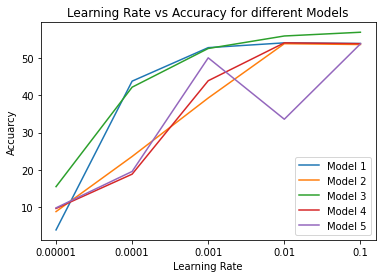

In [24]:
learning_rate_g = ['0.00001', '0.0001', '0.001', '0.01', '0.1']
model_arr_g = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']

plt.plot(learning_rate_g, mat_m1[0], label = "Model 1")
plt.plot(learning_rate_g, mat_m1[1], label = "Model 2")
plt.plot(learning_rate_g, mat_m1[2], label = "Model 3")
plt.plot(learning_rate_g, mat_m1[3], label = "Model 4")
plt.plot(learning_rate_g, mat_m1[4], label = "Model 5")

plt.xlabel('Learning Rate')
plt.ylabel('Accuarcy')
plt.title('Learning Rate vs Accuracy for different Models')
plt.legend(loc='lower right')
plt.show()

#### Models vs Accuracy for different Learning Rates after PCA

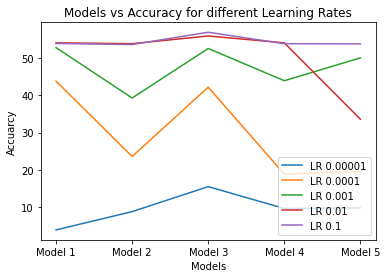

In [25]:
plt.plot(model_arr_g, mat_l1[0], label = "LR 0.00001")
plt.plot(model_arr_g, mat_l1[1], label = "LR 0.0001")
plt.plot(model_arr_g, mat_l1[2], label = "LR 0.001")
plt.plot(model_arr_g, mat_l1[3], label = "LR 0.01")
plt.plot(model_arr_g, mat_l1[4], label = "LR 0.1")

plt.xlabel('Models')
plt.ylabel('Accuarcy')
plt.title('Models vs Accuracy for different Learning Rates')
plt.legend(loc='lower right')
plt.show()

#### Comparison between Best Accuracies of different models (Before PCA and After PCA)  

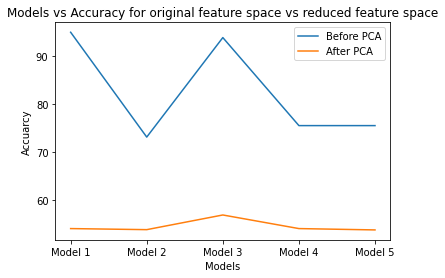

In [26]:
plt.plot(model_arr_g, best_model_acc, label = "Before PCA")
plt.plot(model_arr_g, best_model_acc1, label = "After PCA")

plt.xlabel('Models')
plt.ylabel('Accuarcy')
plt.title('Models vs Accuracy for original feature space vs reduced feature space')
plt.legend(loc='upper right')
plt.show()